<a href="https://colab.research.google.com/github/ShrRa/UNG_OpenDay_ConvDemo/blob/main/ConvolutionDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For opening in Google Colab
#!pip install jupyter_bokeh

In [2]:
import panel as pn
#import holoviews as hv
#from holoviews import opts
import cv2
import time
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
#from bokeh.resources import settings

In [3]:
pn.extension()
pn.extension(design="material")

### Files and directories

In [4]:
kernels = {
    "vertical": np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    "horizontal": np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
    "laplacian": np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]),
}

### Functions

In [5]:
def update_log(message):
    try:
        log.append(message)
        log_output.object = "<br />".join([rec for rec in log])
    except Exception as e:
        log.append(f"update_log error: {e}")
        log_output.object = "<br />".join([rec for rec in log])

In [6]:
def load_orig_img(event):
    image_path = file_selector.value[0]
    update_log(image_path)
    try:
        # image = hv.RGB.load_image(image_path).opts(opts.RGB(width=400, height=300))
        # image = Image.new('RGB', (400, 300), color='white')
        image = Image.open(image_path)
        orig_img_pane.object = image
        orig_img_pane_step.object = Image.open(image_path)
        conv_img_pane.object = Image.new("RGB", image.size, color="gray")
        conv_img_pane_step.object = Image.new("RGB", image.size, color="gray")
        x_slider.end = image.width - 3
        y_slider.end = image.height - 3
        x_slider.value = image.width // 2
        y_slider.value = image.height // 2
    except Exception as e:
        update_log(f"Error loading image: {e}")
    return

In [7]:
def convolve_image(image_path, kernel, pil_or_np="pil"):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            update_log("Error: Could not load image")
            return None

        convolved_img = cv2.filter2D(img, -1, kernel)
        if pil_or_np == "pil":
            convolved_img = Image.fromarray(convolved_img)
        return convolved_img
    except Exception as e:
        update_log(f"convolve_image error: {e}")
    return

In [8]:
def arr_to_img(kernel):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(kernel, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.tight_layout()
    plt.close()
    return fig

In [9]:
# Function to update the displayed images
def update_kernels(event):
    try:
        active_kernel = selector_kernel.value
        for name, pane in kernel_panes.items():
            if name == active_kernel:
                pane.styles = {"opacity": "1"}
            else:
                pane.styles = {"opacity": "0.5"}
        w, h = kernel_pane.width, kernel_pane.height
        kernel_pane.object = kernel_panes[active_kernel].object
        kernel_pane.width = 100
        conv_img_pane_step.object = Image.new(
            "RGB", conv_img_pane_step.object.size, color="gray"
        )
    except Exception as e:
        update_log(f"update_kernels error: {e}")

In [10]:
def start_convolution(event):
    try:
        image_path = file_selector.value[0]
        kernel = kernels[selector_kernel.value]
        convolved_img = convolve_image(image_path, kernel)

        width, height = convolved_img.size
        part_width = 3
        part_height = 3
        revealed_image = Image.new("RGB", (width, height), color="gray")
        for i in range(0, height, part_height):
            for j in range(0, width, part_width):
                part = convolved_img.crop(
                    (j, i, min(j + part_width, width), min(i + part_height, height))
                )
                revealed_image.paste(part, (j, i))
                conv_img_pane.object = revealed_image
                time.sleep(0.005)
    except Exception as e:
        update_log(f"Error revealing image: {e}")
    return

In [11]:
def draw_rec(event):
    try:
        # load_orig_img(event)
        # img = Image.new('RGB', orig_img_pane.object.size, color='gray')
        # img.paste(orig_img_pane.object)
        image_path = file_selector.value[0]
        kernel = kernels[selector_kernel.value]
        convolved_img = convolve_image(image_path, kernel)

        img = orig_img_pane.object.copy()
        orig_img_pane_step.object = img
        draw = ImageDraw.Draw(img)
        x_coord = x_slider.value
        y_coord = y_slider.value
        (width, height) = orig_img_pane.object.size
        draw.rectangle(
            [(x_coord, y_coord), (x_coord + 3, y_coord + 3)], outline="red", width=1
        )
        orig_img_pane_step.object = img
        part_width, part_height = 3, 3
        part = orig_img_pane.object.crop(
            (
                x_coord,
                y_coord,
                min(x_coord + part_width, width),
                min(y_coord + part_height, height),
            )
        )
        # img_part_pane.object = part.resize(img_part_pane.object.size)
        img_part_pane.object = arr_to_img(part)
        img_part_pane.width = 100
        part_conv = convolved_img.crop(
            (
                x_coord,
                y_coord,
                min(x_coord + part_width, width),
                min(y_coord + part_height, height),
            )
        )
        conv_part_pane.object = arr_to_img(part_conv)
        conv_part_pane.width = 100

        revealed_image = conv_img_pane_step.object
        revealed_image.paste(part_conv, (x_coord, y_coord))
        conv_img_pane_step.object = revealed_image

    except Exception as e:
        update_log(f"Error drawing on image: {e}")

In [12]:
def reveal_full_convolution(event):
    try:
        image_path = file_selector.value[0]
        kernel = kernels[selector_kernel.value]
        convolved_img = convolve_image(image_path, kernel)
        conv_img_pane_step.object = convolved_img
    except Exception as e:
        update_log(f"reveal_full_convolution image: {e}")

In [13]:
def update_kernels_multi(event):
    try:
        active_images = multiselector_kernel.value
        for name, pane in kernel_panes.items():
            if name in active_images:
                pane.styles = {"opacity": "1"}
            else:
                pane.styles = {"opacity": "0.5"}
        kernel_pane.object = Image.new("RGB", (100, 100), color="gray")
        conv_img_pane_step.object = Image.new(
            "RGB", conv_img_pane_step.object.size, color="gray"
        )
    except Exception as e:
        update_log(f"update_kernels_multi error: {e}")

In [14]:
def multi_convolutions(event):
    try:
        convolved_imgs = []
        if multiselector_kernel.value == []:
            multiselector_kernel.value = multiselector_kernel.options[:3]
            update_log("No kernels selected; select first three kernels internally")
        for i, selector in enumerate(multiselector_kernel.value):
            convolved_img = convolve_image(
                file_selector.value[0], kernels[selector], pil_or_np="np"
            )
            multi_conv_panes[i].object = Image.fromarray(convolved_img)
            convolved_imgs.append(convolved_img)
        for i in range(len(multiselector_kernel.value), len(multi_conv_panes)):
            multi_conv_panes[i].object = Image.new(
                "RGB", multi_conv_panes[i].object.size, color="gray"
            )
        multi_conv_img = combine_images(convolved_imgs)
        RGB_pane.object = multi_conv_img
        update_log("Combined image sent to the pane")
    except Exception as e:
        update_log(f"multi_convolutions error: {e}")

In [15]:
def combine_images(images):
    try:
        min_height = min(image.shape[0] for image in images)
        min_width = min(image.shape[1] for image in images)
        resized_images = [
            cv2.resize(image, (min_width, min_height)) for image in images
        ]
        combined_img = np.stack(resized_images, axis=2)
        update_log("Multi conv images combined")
        return Image.fromarray(combined_img)
    except Exception as e:
        update_log(f"combine_images error:{e}")

### Layout

In [16]:
# Create image panes
kernel_panes = {
    name: pn.pane.Image(
        object=arr_to_img(kernel), width=100, height=100, styles={"opacity": "0.5"}
    )
    for name, kernel in kernels.items()
}

# Create the toggle group
selector_kernel = pn.widgets.RadioButtonGroup(
    name="Select Kernel",
    options=list(kernel_panes.keys()),
    button_type="primary",
    align="center",
)

selector_kernel.param.watch(update_kernels, "value");

### Common layout elements

In [17]:
logos = {}
logos["smash"] = pn.pane.SVG("./icons/SMASH_logo.svg", height=60, align="center")
logos["ung"] = pn.pane.SVG("./icons/UNG_logo.svg", height=70, align="center")
logos["slovenia"] = pn.pane.PNG("./icons/slovenia_logo.png", height=50, align="center")
logos_pane = pn.Row(*logos.values(), styles={"padding": "30px"}, align="center")
title = pn.pane.Markdown(
    "How do computers <b>see</b>?", styles={"font-size": "40px"}, align="center"
)
header = pn.Row(
    logos_pane,
    title,
    styles={"background-color": "#aac9ea", "padding": "30px"},
    sizing_mode="stretch_width",
)

In [18]:
file_selector = pn.widgets.FileSelector()
file_selector.param.watch(load_orig_img, "value")

Watcher(inst=FileSelector(design=<class 'panel.theme.materi...), cls=<class 'panel.widgets.file_selector.FileSelector'>, fn=<function load_orig_img at 0x7faa6cf5a840>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False, precedence=0)

In [19]:
log_output = pn.pane.Markdown(
    "",
    width=500,
    height=200,
    styles={"background-color": "#eaeaea", "padding": "10px", "margin": "10px"},
)

In [20]:
pic_plus = pn.pane.SVG("./icons/plus.svg", height=60, align="center")
pic_eq = pn.pane.SVG("./icons/eq.svg", height=60, align="center")

### Rapid convolution tab

In [21]:
kernel_selector = pn.Column(
    selector_kernel, pn.Row(*kernel_panes.values()), align="center"
)
convolve_button = pn.widgets.Button(
    name="Start convolution", button_type="success", align="center"
)
convolve_button.on_click(start_convolution)
orig_img_pane = pn.pane.Image(object=Image.new("RGB", (400, 300), color="gray"))
conv_img_pane = pn.pane.Image(object=Image.new("RGB", (400, 300), color="gray"))
conv_rapid = pn.Column(
    kernel_selector,
    convolve_button,
    pn.Row(orig_img_pane, conv_img_pane),
    name="Quick convolution",
)

### Step by step tab

In [22]:
orig_img_pane_step = pn.pane.Image(object=Image.new("RGB", (400, 300), color="gray"))
conv_img_pane_step = pn.pane.Image(object=Image.new("RGB", (400, 300), color="gray"))
img_part_pane = pn.pane.Image(
    object=Image.new("RGB", (100, 100), color="gray"), width=100
)
kernel_pane = pn.pane.Image(
    object=Image.new("RGB", (100, 100), color="gray"), width=100
)
conv_part_pane = pn.pane.Image(
    object=Image.new("RGB", (100, 100), color="gray"), align="center", width=100
)

x_slider = pn.widgets.EditableIntSlider(
    name="X Position",
    start=0,
    end=orig_img_pane.object.width,
    value=orig_img_pane.object.width // 2,
)
y_slider = pn.widgets.EditableIntSlider(
    name="Y Position",
    start=0,
    end=orig_img_pane.object.height,
    value=orig_img_pane.object.height // 2,
)
x_slider.param.watch(draw_rec, "value")
y_slider.param.watch(draw_rec, "value")

reveal_button = pn.widgets.Button(
    name="Reveal full image", button_type="success", align="center"
)
reveal_button.on_click(reveal_full_convolution);

In [23]:
conv_step = pn.Column(
    kernel_selector,
    pn.Row(pn.Column(x_slider, y_slider), reveal_button),
    pn.Row(
        orig_img_pane_step,
        pn.Column(pn.Row(img_part_pane, pic_plus, kernel_pane), pic_eq, conv_part_pane),
        conv_img_pane_step,
    ),
    name="Step by step convolution",
    align="center",
)

### Convolution as channels tab

In [24]:
multiselector_kernel = pn.widgets.CheckButtonGroup(
    name="Select Kernel",
    options=list(kernel_panes.keys()),
    button_type="primary",
    align="center",
)
multiselector_kernel.param.watch(update_kernels_multi, "value");

In [25]:
kernel_multiselector = pn.Column(
    multiselector_kernel, pn.Row(*kernel_panes.values()), align="center"
)

multi_button = pn.widgets.Button(
    name="Combine multiple convolutions", button_type="success", align="center"
)

R_pane = pn.pane.Image(object=Image.new("RGB", (200, 200), color="gray"))
G_pane = pn.pane.Image(object=Image.new("RGB", (200, 200), color="gray"))
B_pane = pn.pane.Image(object=Image.new("RGB", (200, 200), color="gray"))
multi_conv_panes = [R_pane, G_pane, B_pane]
RGB_pane = pn.pane.Image(object=Image.new("RGB", (200, 200), color="gray"))

In [26]:
multi_button.on_click(multi_convolutions);

In [27]:
conv_channels = pn.Column(
    kernel_multiselector,
    multi_button,
    pn.Row(R_pane, pic_plus.clone(), G_pane, pic_plus, B_pane, pic_eq, RGB_pane),
    name="Different kernels combined",
)

### Full layout

In [28]:
layout = pn.Column(
    header,
    pn.Card(
        pn.Row(file_selector, log_output),
        title="Open image...",
        styles={"margin": "30px", "padding": "50px", "padding-bottom": "80px"},
    ),
    pn.Tabs(conv_rapid, conv_step, conv_channels),
    styles={"padding-left": "50px", "padding-right": "50px"},
)
layout.servable();

Column(design=<class 'panel.theme.materi..., styles={'padding-left': '50px', ...})
    [0] Row(design=<class 'panel.theme.materi..., sizing_mode='stretch_width', styles={'background-color': '#aac...})
        [0] Row(align='center', design=<class 'panel.theme.materi..., styles={'padding': '30px'})
            [0] SVG(str, align='center', design=<class 'panel.theme.materi..., height=60)
            [1] SVG(str, align='center', design=<class 'panel.theme.materi..., height=70)
            [2] PNG(str, align='center', design=<class 'panel.theme.materi..., height=50)
        [1] Markdown(str, align='center', design=<class 'panel.theme.materi..., styles={'font-size': '40px'})
    [1] Card(design=<class 'panel.theme.materi..., styles={'margin': '30px', ...}, title='Open image...')
        [0] Row(design=<class 'panel.theme.materi...)
            [0] FileSelector(design=<class 'panel.theme.materi...)
            [1] Markdown(str, design=<class 'panel.theme.materi..., height=200, sizing_mode='fixed', styles={'background-color': '#eae...}, width=500)
    [2] Tabs(design=<class 'panel.theme.materi...)
        [0] Column(design=<class 'panel.theme.materi..., name='Quick convolution')
            [0] Column(align='center', design=<class 'panel.theme.materi...)
                [0] RadioButtonGroup(align='center', button_type='primary', design=<class 'panel.theme.materi..., name='Select Kernel', options=['vertical', 'horizontal',...], value='vertical')
                [1] Row(design=<class 'panel.theme.materi...)
                    [0] Image(Figure, design=<class 'panel.theme.materi..., height=100, sizing_mode='fixed', styles={'opacity': '0.5'}, width=100)
                    [1] Image(Figure, design=<class 'panel.theme.materi..., height=100, sizing_mode='fixed', styles={'opacity': '0.5'}, width=100)
                    [2] Image(Figure, design=<class 'panel.theme.materi..., height=100, sizing_mode='fixed', styles={'opacity': '0.5'}, width=100)
            [1] Button(align='center', button_type='success', design=<class 'panel.theme.materi..., name='Start convolution')
            [2] Row(design=<class 'panel.theme.materi...)
                [0] Image(Image, design=<class 'panel.theme.materi...)
                [1] Image(Image, design=<class 'panel.theme.materi...)
        [1] Column(align='center', design=<class 'panel.theme.materi..., name='Step by step c...)
            [0] Column(align='center', design=<class 'panel.theme.materi...)
                [0] RadioButtonGroup(align='center', button_type='primary', design=<class 'panel.theme.materi..., name='Select Kernel', options=['vertical', 'horizontal',...], value='vertical')
                [1] Row(design=<class 'panel.theme.materi...)
                    [0] Image(Figure, design=<class 'panel.theme.materi..., height=100, sizing_mode='fixed', styles={'opacity': '0.5'}, width=100)
                    [1] Image(Figure, design=<class 'panel.theme.materi..., height=100, sizing_mode='fixed', styles={'opacity': '0.5'}, width=100)
                    [2] Image(Figure, design=<class 'panel.theme.materi..., height=100, sizing_mode='fixed', styles={'opacity': '0.5'}, width=100)
            [1] Row(design=<class 'panel.theme.materi...)
                [0] Column(design=<class 'panel.theme.materi...)
                    [0] EditableIntSlider(design=<class 'panel.theme.materi..., end=400, name='X Position', value=200, width=300)
                    [1] EditableIntSlider(design=<class 'panel.theme.materi..., end=300, name='Y Position', value=150, width=300)
                [1] Button(align='center', button_type='success', design=<class 'panel.theme.materi..., name='Reveal full image')
            [2] Row(design=<class 'panel.theme.materi...)
                [0] Image(Image, design=<class 'panel.theme.materi...)
                [1] Column(design=<class 'panel.theme.materi...)
                    [0] Row(design=<class 'panel.theme.materi...)
                        [0] Image(Image, design=<class 'panel.th
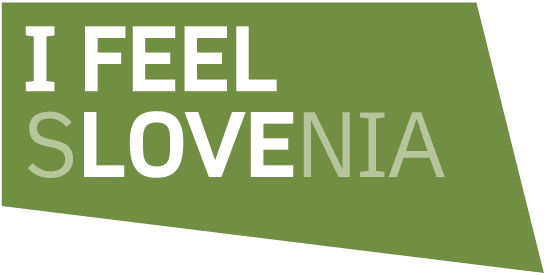
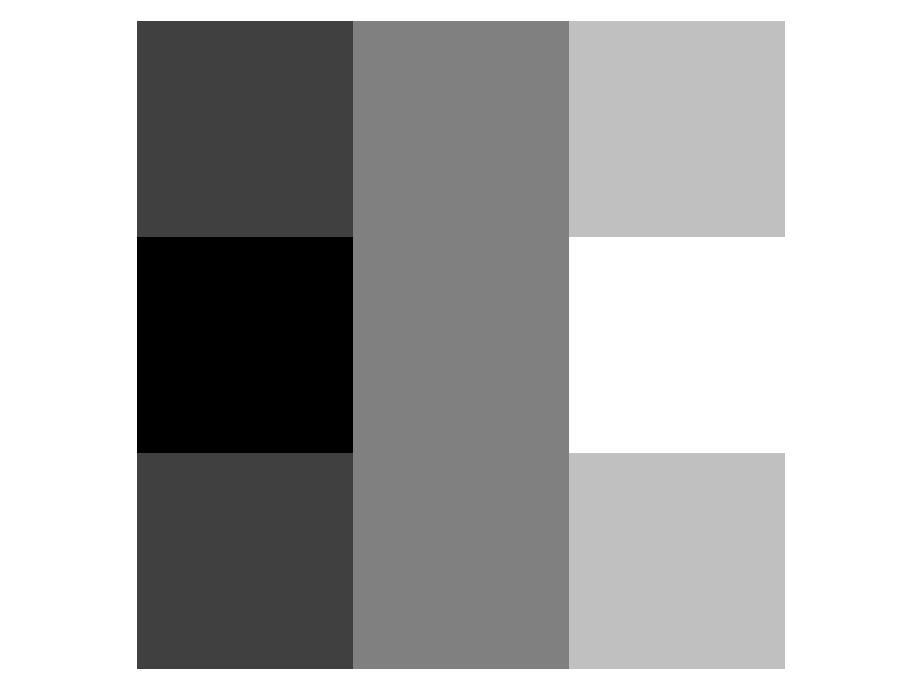
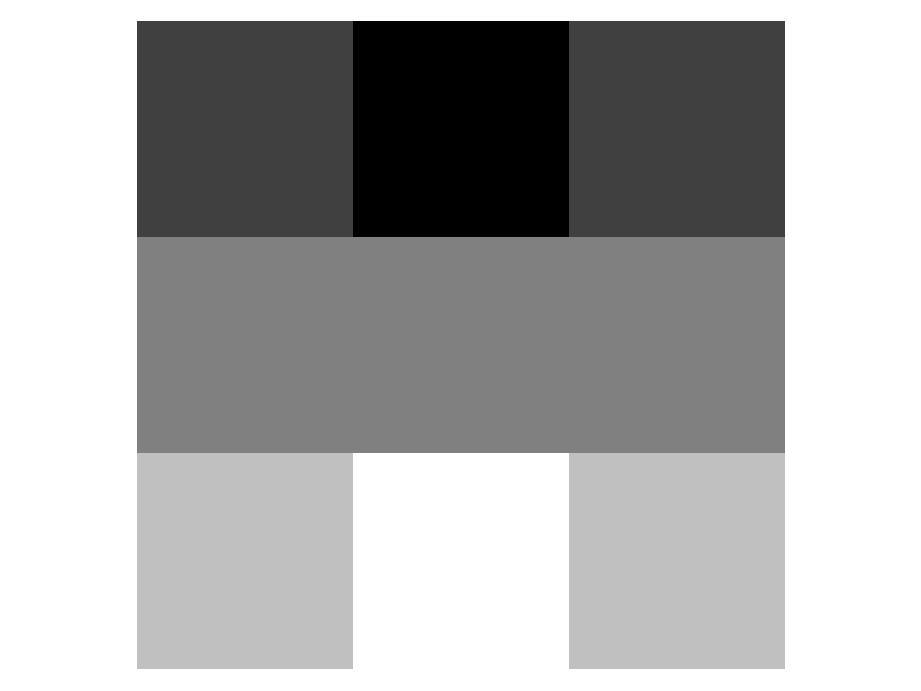
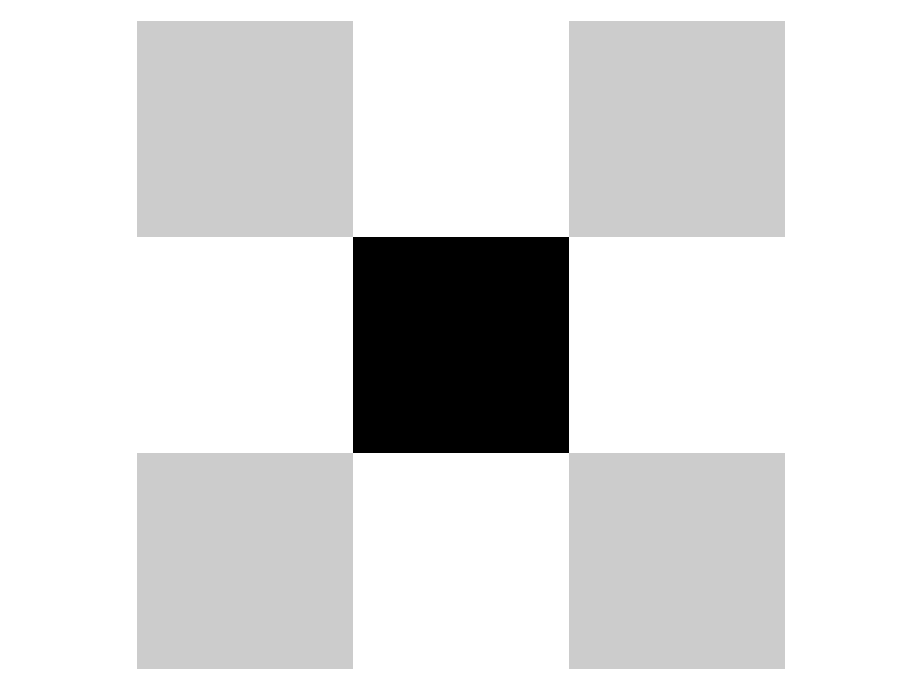
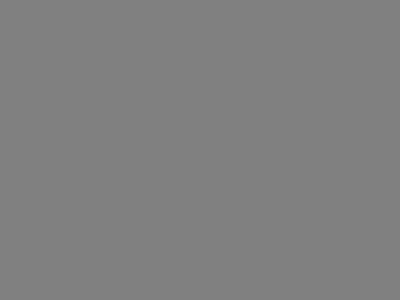
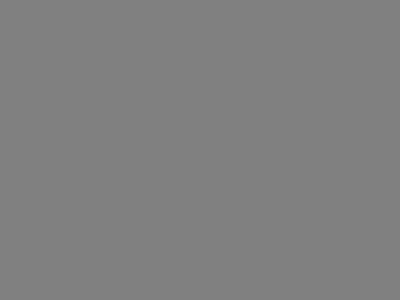
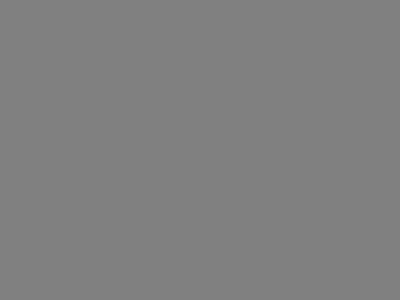
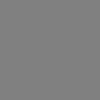
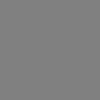
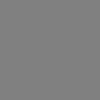
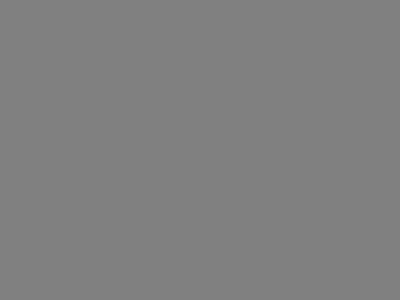
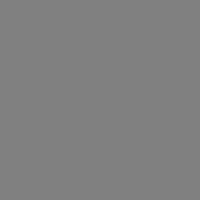
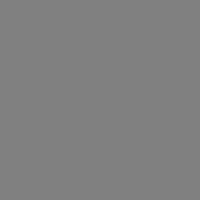
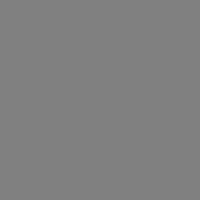
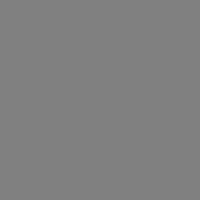

In [29]:
log = []
layout